### Exploring Luxury Beauty Reviews and Trend Analysis - Cleaning

In [1]:
#loading packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json

import os 
import statsmodels.api as sm
import plotly.express as px
import re
import gzip
from urllib.request import urlopen
from statsmodels.api import tsa

In [2]:
#Setting figure size & background 
plt.rcParams['figure.figsize'] = (8.0, 6.0)
sns.set_theme(style="darkgrid")

### Handling nulls

#### Cleaning Review Data set 

In [3]:
#directing to the right file path
os.chdir("/Users/mac/Desktop/Data/CAPSTONE")
cwd = os.getcwd() 

In [4]:
#Opening the reviews,  resource: https://towardsdatascience.com/load-yelp-reviews-or-other-huge-json-files-with-ease-ad804c2f1537
review_df = []
r_dtypes = {"overall": np.float16, 
            "verified": np.int32, 
            "vote": np.int32,
            "reviewTime": np.int32,
            "reviewerID": np.int32,
            "asin": object,
            "reviewerName": object,
            "reviewText":object , 
            "summary": object,     
            "style": object, 
            "image": object, 
           }
with open("Luxury_Beauty.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['unixReviewTime'],axis=1)
        review_df.append(reduced_chunk)
    
review_df = pd.concat(review_df, ignore_index=True)

In [5]:
#checking review_df dataset
review_df.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,style,image
0,2.0,3,1,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,NaN,NaN
1,5.0,14,1,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,NaN,NaN


#### Review Data Dictionary

| Column Name    | Column Contents                                                           |
|----------------|---------------------------------------------------------------------------|
| `overall`      | Rating given by user out of 5.0 (numeric)                                 |
| `verified`     | Denotes verified purchases or not (numeric)                               |
| `vote`         | Number of users that have liked the review (numeric)                      |
| `reviewTime`   | Recorded time of review (numeric)                                         |
| `reviewerID`   | Unique reviewer ID (object)                                               |
| `reviewerName` | Name given of reviewer (object)                                           |
| `reviewText`   | Body of user review (object)                                              |
| `summary`      | Title of user review (object                                              |
| `style`        | Dictionary object containing details on the product reviewed (dictionary) |
| `image`        | Associated images in JPEGs of the product uploaded by user (object)       |

#### Metadata Dictionary

| Column Name              | Column Contents                                                     |
|--------------------------|---------------------------------------------------------------------|
| `category`               | object                                                              |
| `description`            | Description of product                                              |
| `fit`                    | Number of users that have liked the review (object)                 |
| `title`                  | product headline (object)                                           |
| `also_buy`               | related ASINs that purchasers have also bought (object)             |
| `tech2`                  | first technical detail table of the product (object)                |
| `brand`                  | brand name (object)                                                 |
| `feature`                | (object)                                                            |
| `rank`                   | ranking of the category at the time of the data extraction (object) |
| `also_view`              | related ASINs, those that have also been viewed (list)              |
| `details`                | (object)                                                            |
| `Shipping Weight`        | (object)                                                            |
| `International Shipping` | (object)                                                            |
| `ASIN`                   | (object)                                                            |
| `Item model number`      | (object)                                                            |
| `main_cat`               | (object)                                                            |
| `similar_item`           | (object)                                                            |
| `date`                   | (object)                                                            |
| `price`                  | (object)                                                            |
| `asin`                   | (object)                                                            |
| `imageURL`               | url of the product image (list)                                     |
| `imageURLHighRes`        | url of the high resolution product image (list)                     |

In [7]:
#checking amount of nulls   
nan_count = review_df.isna().sum()
print(nan_count)

overall              0
vote            470939
verified             0
reviewTime           0
reviewerID           0
asin                 0
reviewerName        31
reviewText         400
summary            183
style           323615
image           567210
dtype: int64


`Image`, `Vote`, `Style` all have high levels of null values. However we want to keep `Vote` column by filling with 0s since this is an indication of other users agreeing with the review written. Before we move on we should explore the style column to see if there is any useful information there since data is stored in a dictionary.

In [8]:
#filling Vote column nulls with 0

review_df['vote']= review_df['vote'].str.replace(",","").astype("float32")
review_df["vote"].fillna(0, inplace = True)

In [9]:
#converting vote column to vote
print(review_df.dtypes)

overall         float16
vote            float32
verified          int32
reviewTime       object
reviewerID       object
asin             object
reviewerName     object
reviewText       object
summary          object
style            object
image            object
dtype: object


In [10]:
review_df.shape

(574628, 11)

In [11]:
review_df.describe()

,overall,vote,verified
count,574628.0,574628.000000,574628.000000
mean,NaN,1.335126,0.878032
std,0.0,12.092627,0.327249
min,1.0,0.000000,0.000000
25%,4.0,0.000000,1.000000
50%,5.0,0.000000,1.000000
75%,5.0,0.000000,1.000000
max,5.0,2995.000000,1.000000


In [12]:
#sanity check
review_df["vote"].isna().sum()

0

In [13]:
#creating a new df for style
style_df = review_df["style"].apply(pd.Series)


In [14]:
#checking for null values in style column broken out
style_df.isnull().sum()
p = (style_df["Size:"].isna().sum()/review_df.shape[0])*100
print(f"Even column with the lowest amount of nulls, size: still contains {round(p,2)}% of null values which is quite a lot so we can drop the Style column altogether")

Even column with the lowest amount of nulls, size: still contains 75.67% of null values which is quite a lot so we can drop the Style column altogether


In [15]:
review_df['reviewTime'] = review_df['reviewTime'].str.replace(",","")
review_df[['day','month',"year"]] = review_df["reviewTime"].str.split(" ", expand = True).astype('int32')
review_df

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,style,image,day,month,year
0,2.0,3.0,1,06 15 2010,A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,NaN,NaN,6,15,2010
1,5.0,14.0,1,01 7 2010,A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,NaN,NaN,1,7,2010
2,5.0,0.0,1,04 18 2018,A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,{'Size:': ' 3.5 oz.'},NaN,4,18,2018
3,5.0,0.0,1,04 18 2018,A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,{'Size:': ' 3.5 oz.'},NaN,4,18,2018
4,5.0,0.0,1,04 17 2018,A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,{'Size:': ' 3.5 oz.'},NaN,4,17,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574623,5.0,0.0,1,03 20 2017,AHYJ78MVF4UQO,B01HIQEOLO,Lori Fox,Great color and I prefer shellac over gel,Five Stars,NaN,NaN,3,20,2017
574624,5.0,0.0,1,10 26 2016,A1L2RT7KBNK02K,B01HIQEOLO,Elena,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,NaN,NaN,10,26,2016
574625,5.0,0.0,1,09 30 2016,A36MLXQX9WPPW9,B01HIQEOLO,Donna D. Harris,Great polish and beautiful color!!,Great polish!,NaN,NaN,9,30,2016
574626,1.0,2.0,1,12 5 2016,A23DRCOMC2RIXF,B01HJ2UY0W,Y.Y. Chen,"The perfume is good, but the spray head broke ...",Spray head broke off within a month,"{'Size:': ' 1.7 Fluid Ounce', 'Color:': ' Multi'}",NaN,12,5,2016


In [16]:
review_df['reviewdate'] =pd.to_datetime(review_df['reviewTime'],
                                        dayfirst=True)


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_1259/2868718429.py:1: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  review_df['reviewdate'] =pd.to_datetime(review_df['reviewTime'],


In [17]:
review_df['reviewdate'] = pd.to_datetime(review_df['reviewdate']).dt.tz_localize(None)

In [18]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574628 entries, 0 to 574627
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   overall       574628 non-null  float16       
 1   vote          574628 non-null  float32       
 2   verified      574628 non-null  int32         
 3   reviewTime    574628 non-null  object        
 4   reviewerID    574628 non-null  object        
 5   asin          574628 non-null  object        
 6   reviewerName  574597 non-null  object        
 7   reviewText    574228 non-null  object        
 8   summary       574445 non-null  object        
 9   style         251013 non-null  object        
 10  image         7418 non-null    object        
 11  day           574628 non-null  int32         
 12  month         574628 non-null  int32         
 13  year          574628 non-null  int32         
 14  reviewdate    574628 non-null  datetime64[ns]
dtypes: datetime64[ns]

In [19]:
#Removing columns with null values greater than 80% https://stackoverflow.com/questions/43311555/how-to-drop-column-according-to-nan-percentage-for-dataframe 
#style_df = style_df.loc[:, style_df.isnull().mean() < .5]

In [20]:
review_df

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,style,image,day,month,year,reviewdate
0,2.0,3.0,1,06 15 2010,A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,NaN,NaN,6,15,2010,2010-06-15
1,5.0,14.0,1,01 7 2010,A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,NaN,NaN,1,7,2010,2010-07-01
2,5.0,0.0,1,04 18 2018,A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,{'Size:': ' 3.5 oz.'},NaN,4,18,2018,2018-04-18
3,5.0,0.0,1,04 18 2018,A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,{'Size:': ' 3.5 oz.'},NaN,4,18,2018,2018-04-18
4,5.0,0.0,1,04 17 2018,A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,{'Size:': ' 3.5 oz.'},NaN,4,17,2018,2018-04-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574623,5.0,0.0,1,03 20 2017,AHYJ78MVF4UQO,B01HIQEOLO,Lori Fox,Great color and I prefer shellac over gel,Five Stars,NaN,NaN,3,20,2017,2017-03-20
574624,5.0,0.0,1,10 26 2016,A1L2RT7KBNK02K,B01HIQEOLO,Elena,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,NaN,NaN,10,26,2016,2016-10-26
574625,5.0,0.0,1,09 30 2016,A36MLXQX9WPPW9,B01HIQEOLO,Donna D. Harris,Great polish and beautiful color!!,Great polish!,NaN,NaN,9,30,2016,2016-09-30
574626,1.0,2.0,1,12 5 2016,A23DRCOMC2RIXF,B01HJ2UY0W,Y.Y. Chen,"The perfume is good, but the spray head broke ...",Spray head broke off within a month,"{'Size:': ' 1.7 Fluid Ounce', 'Color:': ' Multi'}",NaN,12,5,2016,2016-05-12


In [21]:
#Removing unnecessary columns and Image
columns = ["style","image"]
for column in columns: 
     review_df = review_df.drop([column],axis=1)

In [22]:
nan_count = review_df.isna().sum()
print(nan_count)

overall           0
vote              0
verified          0
reviewTime        0
reviewerID        0
asin              0
reviewerName     31
reviewText      400
summary         183
day               0
month             0
year              0
reviewdate        0
dtype: int64


In [23]:
#replacing na values of reviewer name with reviewer ID 
review_df['reviewerName'] =review_df.loc[:,'reviewerName'].fillna(review_df["reviewerID"])

In [24]:
nan_count = review_df.isna().sum()
print(nan_count)

overall           0
vote              0
verified          0
reviewTime        0
reviewerID        0
asin              0
reviewerName      0
reviewText      400
summary         183
day               0
month             0
year              0
reviewdate        0
dtype: int64


In [25]:
# % of na values of review_df
pct_reviewText = review_df["reviewText"].isna().sum()/review_df.shape[0]*100
print(f"Null values of reviewText makes up {round(pct_reviewText,2)}% of dataset, this is small so we can remove these lines")

Null values of reviewText makes up 0.07% of dataset, this is small so we can remove these lines


In [26]:
#removing remaining rows with null values and checking row counts, saved to df1
review_df1 = review_df.dropna().copy()
review_df1.shape

(574053, 13)

In [27]:
#sanity check
review_df1.isna().sum().sum()

0

In [28]:
review_df1 = review_df1.drop(columns ="reviewerName")


In [29]:
review_df1

,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,day,month,year,reviewdate
0,2.0,3.0,1,06 15 2010,A1Q6MUU0B2ZDQG,B00004U9V2,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,6,15,2010,2010-06-15
1,5.0,14.0,1,01 7 2010,A3HO2SQDCZIE9S,B00004U9V2,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1,7,2010,2010-07-01
2,5.0,0.0,1,04 18 2018,A2EM03F99X3RJZ,B00004U9V2,Great hand lotion,Five Stars,4,18,2018,2018-04-18
3,5.0,0.0,1,04 18 2018,A3Z74TDRGD0HU,B00004U9V2,This is the best for the severely dry skin on ...,Five Stars,4,18,2018,2018-04-18
4,5.0,0.0,1,04 17 2018,A2UXFNW9RTL4VM,B00004U9V2,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,4,17,2018,2018-04-17
...,...,...,...,...,...,...,...,...,...,...,...,...
574623,5.0,0.0,1,03 20 2017,AHYJ78MVF4UQO,B01HIQEOLO,Great color and I prefer shellac over gel,Five Stars,3,20,2017,2017-03-20
574624,5.0,0.0,1,10 26 2016,A1L2RT7KBNK02K,B01HIQEOLO,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,10,26,2016,2016-10-26
574625,5.0,0.0,1,09 30 2016,A36MLXQX9WPPW9,B01HIQEOLO,Great polish and beautiful color!!,Great polish!,9,30,2016,2016-09-30
574626,1.0,2.0,1,12 5 2016,A23DRCOMC2RIXF,B01HJ2UY0W,"The perfume is good, but the spray head broke ...",Spray head broke off within a month,12,5,2016,2016-05-12


### Row Duplicates

Now that we have dealt with the null values we can move onto checking if we have any duplicates of rows. 

In [30]:
#checking count of duplicated rows 
review_df1.duplicated().sum()

34893

In [31]:
# % of na values of review_df
pct_duplicates = review_df1.duplicated().sum()/review_df1.shape[0]*100
print(f"Duplicate rows make up {round(pct_duplicates,2)} % of dataset, which is fairly large")

Duplicate rows make up 6.08 % of dataset, which is fairly large


In [32]:
#looking at duplicates
review_df1[review_df1.duplicated()].sample(5)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,day,month,year,reviewdate
172404,5.0,0.0,1,12 16 2016,A1MYTYW8B1KKEM,B00172IEXU,"Very gentle, works well, does not dry my face ...",Five Stars,12,16,2016,2016-12-16
169462,1.0,0.0,1,12 14 2013,A1KB1U4YR7Z75,B0015VP9CW,This is the fifth bottle fo Butter I have purc...,Not on my list any longer,12,14,2013,2013-12-14
170440,4.0,0.0,1,02 18 2013,A2IDILDNU6AB97,B0015Z90NC,I love this product line. I decided to try thi...,Good stuff,2,18,2013,2013-02-18
158131,5.0,0.0,1,05 4 2015,A37H8Z25KYU7FJ,B000ZLZMRA,"Great product line, oil adds necessary protect...",Five Stars,5,4,2015,2015-04-05
160308,5.0,2.0,1,11 22 2013,A2DVZMJIKFUG46,B0010P6D28,! This stuff really works. My neck was itchy a...,Love this Nectifirm!,11,22,2013,2013-11-22


In [33]:
pct_origin_row = review_df.duplicated().sum() /review_df.duplicated(keep=False).sum()
print(f"Each duplicated row appears close to twice at {round(pct_origin_row,2)}% of the dataset, so there was likely a data recording issue.")

Each duplicated row appears close to twice at 0.51% of the dataset, so there was likely a data recording issue.


In [34]:
#removing duplicates
review_df1 = review_df1.drop_duplicates()
review_df1.shape

(539160, 12)

In [35]:
#creating clean review_df and copying in review_df into it 
clean_review_df = pd.DataFrame()
clean_review_df = review_df1.copy()

In [36]:
clean_review_df.isna().sum()

overall       0
vote          0
verified      0
reviewTime    0
reviewerID    0
asin          0
reviewText    0
summary       0
day           0
month         0
year          0
reviewdate    0
dtype: int64

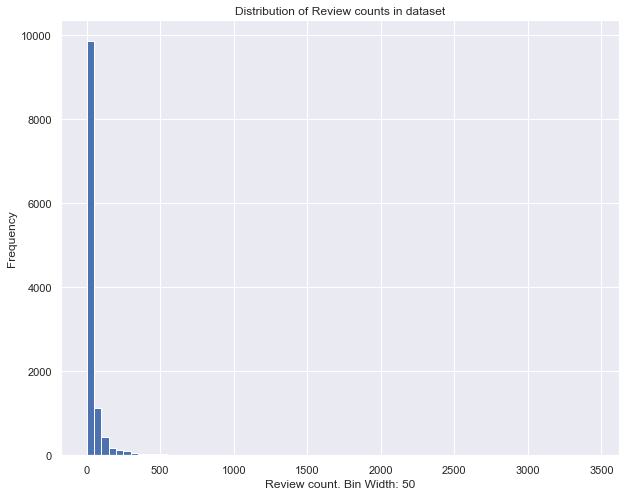

In [37]:
#histogram of reviews 
binwidth = 50

plt.figure(figsize=(10,8))
asin_data = clean_review_df["asin"].value_counts()
plt.hist(asin_data , bins=np.arange(0,3500, binwidth))

plt.xlabel(f'Review count. Bin Width: {binwidth}')
plt.ylabel('Frequency')
plt.title('Distribution of Review counts in dataset')
plt.show()

#### Cleaning Metadata Dataset

In [38]:
#Opening the Meta data 
metadata_df = []
r_dtypes = {"category": object,
            "tech1": object,
            "description": object,
            "fit": object,
            "title": object,
            "also_buy": list,
            "tech2": object, 
            "brand": object,
            "feature": object,
            "rank":object,
            "also_view": list, 
            "details": object,
            "Shipping Weight": object,
            'International Shipping': object,
            "ASIN": object, 
            "Item model number": object,
            "main_cat": object,
            "similar_item": object,
            "date": object,
            "price": np.float32,
            "asin": object, 
            "imageURL": list, 
            "imageURLHighRes": list ,
           }
with open("meta_Luxury_Beauty.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=["tech1"],axis=1)
        metadata_df.append(reduced_chunk)
    
metadata_df = pd.concat(metadata_df, ignore_index=True)

In [39]:
#Row and column count 
metadata_df.shape

(12299, 18)

In [40]:
metadata_df.head(5)

,category,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],[After a long day of handling thorny situation...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",,,[],"4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,Luxury Beauty,,NaT,$30.00,B00004U9V2,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,[],[If you haven't experienced the pleasures of b...,,AHAVA Bath Salts,[],,,[],"1,633,549 in Beauty & Personal Care (",[],{' Product Dimensions: ': '3 x 3.5 x ...,Luxury Beauty,,NaT,,B0000531EN,[],[]
2,[],"[Rich, black mineral mud, harvested from the b...",,"AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4",[],,,[],"1,806,710 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '5.1 x 3 x ...,Luxury Beauty,,NaT,,B0000532JH,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,[],[This liquid soap with convenient pump dispens...,,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",[],,,[],[],"[B00004U9V2, B00GHX7H0A, B00FRERO7G, B00R68QXC...",{' Product Dimensions: ': '2.6 x 2.6 ...,Luxury Beauty,,NaT,$15.99,B00005A77F,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],[Remember why you love your favorite blanket? ...,,Soy Milk Hand Crme,"[B000NZT6KM, B001BY229Q, B008J724QY, B0009YGKJ...",,,[],"42,464 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '7.2 x 2.2 ...,Luxury Beauty,,NaT,$18.00,B00005NDTD,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [41]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12299 entries, 0 to 12298
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         12299 non-null  object
 1   description      12299 non-null  object
 2   fit              12299 non-null  object
 3   title            12299 non-null  object
 4   also_buy         12299 non-null  object
 5   tech2            12299 non-null  object
 6   brand            12299 non-null  object
 7   feature          12299 non-null  object
 8   rank             12299 non-null  object
 9   also_view        12299 non-null  object
 10  details          12299 non-null  object
 11  main_cat         12299 non-null  object
 12  similar_item     12299 non-null  object
 13  date             0 non-null      object
 14  price            12299 non-null  object
 15  asin             12299 non-null  object
 16  imageURL         12299 non-null  object
 17  imageURLHighRes  12299 non-null

There are many empty columns in the dataset, and many with just empty lists or the same value repeated throughout: category, tech1, fit, tech2, brand, feature, main_cat, date. 

Equally since we wont be needing the image URLs we can remove these columns as well.

In [42]:
#removing columns 
columns= ["category", "fit", "tech2", "brand", "feature", "main_cat", "date", "imageURL","imageURLHighRes"]

metadata_df.drop(columns,axis=1, inplace=True)

In [43]:
metadata_df.head(5)

,description,title,also_buy,rank,also_view,details,similar_item,price,asin
0,[After a long day of handling thorny situation...,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,,$30.00,B00004U9V2
1,[If you haven't experienced the pleasures of b...,AHAVA Bath Salts,[],"1,633,549 in Beauty & Personal Care (",[],{' Product Dimensions: ': '3 x 3.5 x ...,,,B0000531EN
2,"[Rich, black mineral mud, harvested from the b...","AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4",[],"1,806,710 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '5.1 x 3 x ...,,,B0000532JH
3,[This liquid soap with convenient pump dispens...,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",[],[],"[B00004U9V2, B00GHX7H0A, B00FRERO7G, B00R68QXC...",{' Product Dimensions: ': '2.6 x 2.6 ...,,$15.99,B00005A77F
4,[Remember why you love your favorite blanket? ...,Soy Milk Hand Crme,"[B000NZT6KM, B001BY229Q, B008J724QY, B0009YGKJ...","42,464 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '7.2 x 2.2 ...,,$18.00,B00005NDTD


In [44]:
#applying NaN values in place of empty lists
metadata_df = metadata_df.where(~metadata_df.applymap(lambda x: x == [] or x is None or x == ''))

In [45]:
#null value count
null_metadata = metadata_df.isna().sum()
null_metadata["price"]

5260

In [46]:
metadata_df[['ranking','remove']] = metadata_df["rank"].str.split(" ", n=1,expand = True)

In [47]:
#convert ranking column to integer
metadata_df['ranking'] = metadata_df["ranking"].str.replace(",", "", regex=False)
metadata_df["ranking"].fillna(0, inplace = True)
metadata_df["ranking"] =metadata_df["ranking"].astype("int32")

In [48]:
#remove unnecessary columns
metadata_df.drop(['remove','rank',"similar_item"],axis=1,inplace=True )

In [49]:
# the second replace just removes repeated whitespaces
# filtered_poems["Content"] = filtered_poems["Content"].str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ")

In [50]:
#removing description from list 
metadata_df['product_description'] = metadata_df['description'].str.join(', ')

In [51]:
#taking a look at details column
d = metadata_df["details"].iloc[0]
d.keys()

dict_keys(['\n    Product Dimensions: \n    ', 'Shipping Weight:', 'Domestic Shipping: ', 'International Shipping: ', 'ASIN:', 'Item model number:'])

Taking a look at the values that are contained in the `details` column, we can pass on these since these don't have much relation to contributing to the individual products. If we didnt already have access to the ASIN then we would keep this value. 

In [52]:
metadata_df.drop(["details","description"],axis=1, inplace=True)

`price` is an object right now, this needs to convert to numeric value. 

In [53]:
#removing dollar sign from price and replacing those values with 0 
metadata_df['price'] = metadata_df["price"].str.replace("$", "", regex=False)
metadata_df["price"].fillna(0, inplace = True)
metadata_df.head(5)

,title,also_buy,also_view,price,asin,ranking,product_description
0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",30.00,B00004U9V2,4324,After a long day of handling thorny situations...
1,AHAVA Bath Salts,NaN,NaN,0,B0000531EN,1633549,If you haven't experienced the pleasures of ba...
2,"AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4",NaN,NaN,0,B0000532JH,1806710,"Rich, black mineral mud, harvested from the ba..."
3,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",NaN,"[B00004U9V2, B00GHX7H0A, B00FRERO7G, B00R68QXC...",15.99,B00005A77F,0,This liquid soap with convenient pump dispense...
4,Soy Milk Hand Crme,"[B000NZT6KM, B001BY229Q, B008J724QY, B0009YGKJ...",NaN,18.00,B00005NDTD,42464,Remember why you love your favorite blanket? T...


In [54]:
metadata_df["price"] = metadata_df["price"].str.strip()

In [55]:
#extracting string from
metadata_df['price_USD']= metadata_df['price'].str.extract(r'(\d*?\.\d{2})', expand=False)
metadata_df['price_USD'] = metadata_df['price_USD'].astype(float)

In [56]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12299 entries, 0 to 12298
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                12299 non-null  object 
 1   also_buy             7724 non-null   object 
 2   also_view            9046 non-null   object 
 3   price                7039 non-null   object 
 4   asin                 12299 non-null  object 
 5   ranking              12299 non-null  int32  
 6   product_description  12149 non-null  object 
 7   price_USD            6958 non-null   float64
dtypes: float64(1), int32(1), object(6)
memory usage: 720.8+ KB


In [57]:
#for loop to get also_buy counts, also_view counts 
columns = ["also_buy","also_view"]

for column in columns: 
    name =  column + "_" + "counts"
    
    #Using explode function to count all of the times each asin appears
    x = metadata_df.explode(column)[column]
    
    my_count = x.value_counts()
    
    #creating a dictionary
    dict_counts = my_count.to_dict()
    
    #assigning the values using the dictionary created and creating a new column
    metadata_df[name] = metadata_df["asin"].map(dict_counts)


In [58]:
#maybe do something about the missing price values?
pct_null_price = (null_metadata["price"]/metadata_df.shape[0])*100
print(f"Price is missing from {round(pct_null_price,2)}% of columns which could be an issue.") 

Price is missing from 42.77% of columns which could be an issue.


In [59]:
metadata_df["also_buy_counts"].fillna(0, inplace = True)
metadata_df["also_view_counts"].fillna(0, inplace = True)

In [135]:

pct_price = (metadata_df["price_USD"].isna().sum()/metadata_df.shape[0])*100
print(f"Price is still an issue with null values that are fairly high taking up {round(pct_price, 2)}% of the data set.  ")


Price is still an issue with null values that are fairly high taking up 43.43% of the data set.  


In [60]:
columns = ['also_buy','also_view',"price_USD"]
for column in columns: 
     metadata_df = metadata_df.drop([column],axis=1)

In [61]:
#checking for duplicates
metadata_df.duplicated().sum()

188

In [62]:
duplicate_df = metadata_df[metadata_df.duplicated()]
duplicate_df

,title,price,asin,ranking,product_description,also_buy_counts,also_view_counts
188,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,30.00,B00004U9V2,4324,After a long day of handling thorny situations...,56.0,48.0
189,AHAVA Bath Salts,NaN,B0000531EN,1633549,If you haven't experienced the pleasures of ba...,0.0,0.0
190,"AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4",NaN,B0000532JH,1806710,"Rich, black mineral mud, harvested from the ba...",0.0,0.0
191,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",15.99,B00005A77F,0,This liquid soap with convenient pump dispense...,0.0,0.0
192,Soy Milk Hand Crme,18.00,B00005NDTD,42464,Remember why you love your favorite blanket? T...,26.0,15.0
...,...,...,...,...,...,...,...
371,"Glycolix Elite Fortified Facial Cream, 1.6 oz",30.50,B0002ZZT5Y,37543,Elite Fortified Facial Cream is fortified with...,36.0,29.0
372,"Glo Minerals Precision Lip Pencil, Rosewood, ....",18.00,B0003MJITY,304392,An advanced mineral liner formulation that gli...,1.0,3.0
373,"Glo Skin Beauty Minerals Blush, Sheer Petal",NaN,B0003MJ9DY,627917,High-pigment mineral makeup blush for expert c...,0.0,0.0
374,Glo Skin Beauty Precision Brow Pencil - Blonde...,20.00,B0003MJFSS,206224,A natural-looking brow enhancement pencil in a...,6.0,4.0


In [63]:
#removing duplicates
metadata_df = metadata_df.drop_duplicates()

In [64]:
#quick check
metadata_df.duplicated().sum()

0

In [65]:
duplicate_df.groupby('asin')['title'].value_counts()

asin        title                                                                                   
B00004U9V2  Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ       1
B0000531EN  AHAVA Bath Salts                                                                            1
B0000532JH  AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4                                               1
B00005A77F  Crabtree &amp; Evelyn Hand Soap, Gardeners, 10.1 fl. oz.                                    1
B00005NDTD  Soy Milk Hand Crme                                                                          1
                                                                                                       ..
B0002ZZT5Y  Glycolix Elite Fortified Facial Cream, 1.6 oz                                               1
B0003MJ9DY  Glo Skin Beauty Minerals Blush, Sheer Petal                                                 1
B0003MJFSS  Glo Skin Beauty Precision Brow Pencil -

Doing a quick groupby the value counts seem to check out as just being duplicates so we can remove these from the dataset. 

`Price` is still an issue with null values that are fairly high taking up #finish

In [66]:
#checking for null values 
metadata_df.isna().sum()

title                     0
price                  5178
asin                      0
ranking                   0
product_description     145
also_buy_counts           0
also_view_counts          0
dtype: int64

if product description is null then we will remove these. 


In [67]:
metadata_df = metadata_df[metadata_df['product_description'].notna()]

In [68]:
metadata_df.isna().sum()

title                     0
price                  5061
asin                      0
ranking                   0
product_description       0
also_buy_counts           0
also_view_counts          0
dtype: int64

In [69]:
metadata_df_clean = metadata_df.copy()

In [70]:
metadata_df_clean.head(2)

,title,price,asin,ranking,product_description,also_buy_counts,also_view_counts
0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,30.00,B00004U9V2,4324,After a long day of handling thorny situations...,56.0,48.0
1,AHAVA Bath Salts,NaN,B0000531EN,1633549,If you haven't experienced the pleasures of ba...,0.0,0.0


### creating category

In [71]:
from collections import defaultdict
title_list = metadata_df_clean["title"].to_list()

temp = defaultdict(int)
 
# memorizing count
for title in title_list:
    for wrd in title.split():
        wrd = wrd.lower()
        
        clean_wrd = ""
        #searching through each letter and only accepting those in the alphabet
        for letter in wrd: 
            if letter >= 'a' and letter <= 'z': 
                clean_wrd = clean_wrd + letter
        temp[clean_wrd] += 1
 

In [72]:
#saving dictionaries for easy access for analyzing the titles
sorted_dict = sorted(temp.items(),key = lambda x:x[1], reverse = True)
sorted_dict_alpha = sorted(temp.items())

In [73]:
#output for csv 
df_dict = pd.DataFrame(sorted_dict_alpha)
df_dict.to_csv("myfile.csv",index=False)

In [74]:
#regex list for mapping out the different categories
regex_list = [r'\skin\B|moisturi[z|s](er|ing)|\bcleans.*(ing|r)\b|cellular|salve|essence|serum|maintenance|digestive|pevonia|micellar|kerr|filorga|complex|cleanse|osmosis|elixir|orlane|concentrate|manuka|stretch mark|cosmedix|clinical|redness|oralne|guinot|clarityrx|bioelements|reconstructor|liftosome|moisture|replenix|goldfaden|fender|mask|epicuren|\bface\b(?!\w*sur)|cell repair|facial|astringent|blinc|\bmasque\b|\bcreme\b|\btoner\b|acne|(?!hair spray)\b(face|facial) spray\b|mio|tired leg|butter|marini|badescu|elemis|youth|antiaging|makeup remover|e.r.3|tonic|body lotion|towelettes|occitane|\b(?<!sun )lotion\b|replenix cf|skincare|nuxe|ahava|crabtree|moisterizing|arden|jurlique|retinol|strivectin|\bremover\b|cream|bliss|\b(?<!hair )oil\b|scrub|acid|derm|skin|body|greyl|pureology|aloe|perricone|wipe|vichy|anti(?!per|oxid|friz)|caudalie|age|borghese|exfol|iredale|bisse|neova|squalane|ceut|neck|red flower|boscia|cellex-c|wrinkle|hyd*' #skincare
              ,r'hair|cond(i)tion|putty|eimi|dr.|klorane|mop|\b(moroccanoil|hard water|paste|inhibition|prevon|silken|teasing|frizz|cloud nine|davines|colorproof|marulaoil|abba|exquisiteoil|salon|chaz dean|milk_shake|oilhair|shampoo|shampooing|hairspray)\b|(?!face|facial)\b(hair|detangling|texture|volumizing) spray\b|protectant|treatment|styling|lipstick|brightening|brow(?!n)|paul mitchell|\b(?<!mist )spray\b|mousse|volumiz|hair oil|curl|texture|somme|wax|oribe|amika|text*|mist|volume|blandi|\bgel\b|rusk|sebastian|chi|rsquo|nioxin|furterer|folli|neuma|root|volumin|blonde(s)' #haircare 
              ,r'\w*(?<!s)nail|\bpolish\b(?!\w*ed|\w*er|\w*es|\w*ing\b)|heel|ridge|cuticle|dry drops|prostay|rgb|manicure|pedicure|crme|\bhand(s)?\b(?!bag)|\bopi\b|zoya|jessica|foot cream|gehwol fusskraft|cnd|coat|palisade|\b(?<!lip )lacquer\b' #nailcare
              ,r'soap(?!holder)|bath|shower(?!cap)|gianna rose|\bwash(?!mouth)|salt|rituals|molton brown|\bmud\b' #bath&shower
              ,r'shadow|beauty|\bli(ps)?\b(?!philip)|liner(?!clineral)|longo|son &amp;|lea journo|bb|mai|cargo|balm|makeup|lip lacquer|alloy|foundation|conceal-it|cosmetics|pencil|\bgloss\b|\bpalette\b|hormone|conceal(er)|\bprimer\b|corrector|mascara|rodial|\bmakeup\b(?! remover)|highlight(ing)|bronzing|bronzer|blush|powder|stila|cosmetic|lorac|\beye\b(?! makeup remover)|dermablend|jouer|highlighter|geller|tint|lash|bronze|contour|base|matte|berry|tonymoly|michelle phan|korres|lip|shadow(?!s)' #makeup
              ,r'eau|toilette|parfum|cologne|perfume|fragrance|rollerball|lolita|aroma|alora|pacifique|montale|alford|mancera|malandrino|woods|\bkenneth\b' #fragance
              ,r'\b(aftershave)|jack black|homme|men|him|man made|shaving|groom|anthony|shave|proglide|deodorant|pomade|razor|perspirant|billy|klein|beard|fusion proglide|baxter|shave|trimmer|shave(?!r)' #menscare
              ,r'tweezer|ts2|brush|showercap|capsule|clip(s)|philip|iron|plie|ddf|cotton|lightstim|purse pack|sponge|file|sharpener|nubrilliance|stephanie johnson|emi|potempa|japonesque|beachwaver|attachment|plate|t3|clarisonic|supplement|candle|papier|vitamin|\bdryer\b|sponge(s)|rollers|ceramic|mouth|tooth|teeth|diffuser|babyliss|\btea\b|comb|temptu|white|mirror|bag|curler|ghd|stand|supersmile|zwilling|ionic|tool(s)'#accessories 
              ,r'sun|spf|sunscreen|\btan\b|st. tropez|\btanning\b|\btanner\b|sun lotion' #suncare
              ,r'\bgift\b|\bset\b|kit|hamper|strop|\btravel\b|box' #other
             ]
                
column_names = ['c_skincare','c_haircare','c_nailandhands','c_bath&shower','c_makeup','c_fragance','c_menscare','c_accessories','c_suncare','c_other']


In [75]:
#for loop to create columns and then prints out the number of matches 
for column,regex_search in zip(column_names, regex_list):
    
    metadata_df_clean[column] = metadata_df_clean["title"].str.contains(
    regex_search
    , regex = True
    , case=False )
    counts = metadata_df_clean[column].sum()
    print(f"{column} column created with {counts} matches")
    

/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_1259/2954263219.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  metadata_df_clean[column] = metadata_df_clean["title"].str.contains(


c_skincare column created with 6604 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_1259/2954263219.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  metadata_df_clean[column] = metadata_df_clean["title"].str.contains(


c_haircare column created with 4782 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_1259/2954263219.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  metadata_df_clean[column] = metadata_df_clean["title"].str.contains(


c_nailandhands column created with 1044 matches
c_bath&shower column created with 784 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_1259/2954263219.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  metadata_df_clean[column] = metadata_df_clean["title"].str.contains(


c_makeup column created with 3268 matches
c_fragance column created with 1493 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_1259/2954263219.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  metadata_df_clean[column] = metadata_df_clean["title"].str.contains(


c_menscare column created with 1668 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_1259/2954263219.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  metadata_df_clean[column] = metadata_df_clean["title"].str.contains(


c_accessories column created with 1988 matches
c_suncare column created with 594 matches
c_other column created with 799 matches


In [76]:
#creating new column for category
mapping_dict = { False: None
                , 'c_skincare': 'skincare'
                , 'c_haircare': 'haircare'
                , 'c_nailandhands': 'nails and hands'
                ,'c_bath&shower' : 'bath and shower'
                ,'c_makeup' : 'makeup'
                ,'c_fragance' : 'fragance'
                ,'c_accessories' : 'accessories'
                , 'c_menscare' : 'menscare'
                , 'c_other' : 'other'
                , 'c_suncare' : 'suncare'
               }

df_cat = metadata_df_clean.filter(like='c_')
metadata_df_clean['category'] = (df_cat.idxmax(axis=1).map(mapping_dict)
                    .where(df_cat.any(axis=1), mapping_dict[False]))
print (metadata_df_clean['category'])

0               skincare
1               skincare
2               skincare
3               skincare
4        nails and hands
              ...       
12294    nails and hands
12295    nails and hands
12296    nails and hands
12297           fragance
12298           fragance
Name: category, Length: 11966, dtype: object


In [77]:
#sanity check 
metadata_null = metadata_df_clean[metadata_df_clean['category']=='none']
metadata_null.shape

(0, 18)

In [78]:
#remove the c columns
column_names = ['c_skincare','c_haircare','c_nailandhands','c_bath&shower','c_makeup','c_fragance','c_menscare','c_accessories','c_suncare','c_other']

for column in column_names: 
    metadata_df_clean.drop([column],axis=1, inplace=True)

In [79]:
metadata_df_clean.isna().sum()

title                     0
price                  5061
asin                      0
ranking                   0
product_description       0
also_buy_counts           0
also_view_counts          0
category                  1
dtype: int64

In [80]:
na_df = metadata_df_clean[metadata_df_clean['category'].isna()]
na_df

,title,price,asin,ranking,product_description,also_buy_counts,also_view_counts,category
4406,"skyn ICELAND Angelica Line Smoother, 1.5 fl. oz.",NaN,B005G0WAWA,481615,"When skin endures the stress of daily life, wr...",0.0,0.0,None


In [81]:
#dont know if I need this anymore
"""
for column,regex_search in zip(column_names, regex_list):
    
    na_df[column] = na_df["title"].str.contains(
    regex_search
    , regex = True
    , case=False )
    counts = na_df[column].sum()
    print(f"{column} column created with {counts} matches")
    
"""

'\nfor column,regex_search in zip(column_names, regex_list):\n    \n    na_df[column] = na_df["title"].str.contains(\n    regex_search\n    , regex = True\n    , case=False )\n    counts = na_df[column].sum()\n    print(f"{column} column created with {counts} matches")\n    \n'

group by product, order by time, and then see what would look like (poss window function)

### Analysis 

In [83]:
#splitting out Day month year from reviewtime
clean_review_df['reviewTime'] = review_df['reviewTime'].str.replace(",","")
clean_review_df[['day','month',"year"]] = clean_review_df["reviewTime"].str.split(" ", expand = True)

In [84]:
#separating columns of clean_review_df
clean_review_df[['day','month',"year"]] = clean_review_df["reviewTime"].str.split(" ", expand = True).astype("int32")
clean_review_df.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,day,month,year,reviewdate
0,2.0,3.0,1,06 15 2010,A1Q6MUU0B2ZDQG,B00004U9V2,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,6,15,2010,2010-06-15
1,5.0,14.0,1,01 7 2010,A3HO2SQDCZIE9S,B00004U9V2,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1,7,2010,2010-07-01


In [85]:
clean_review_df =clean_review_df.drop(columns = "reviewTime")

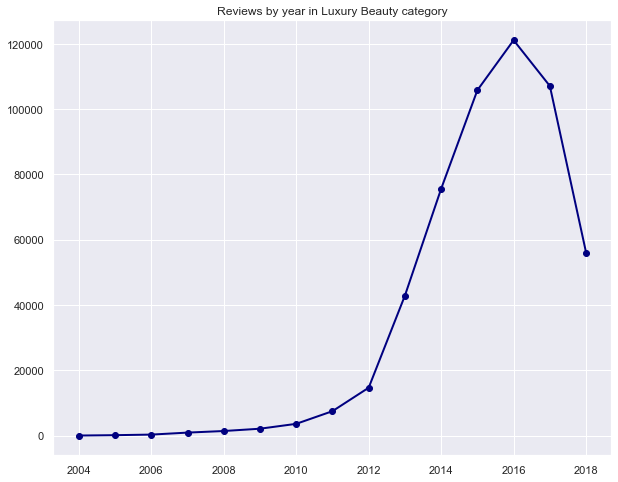

In [86]:
#Looking at number of reviews over the years 
plt.figure(figsize=(10,8))
clean_review_df['year'].value_counts().sort_index().plot(linewidth=2, marker ='o', color = "navy")

plt.title("Reviews by year in Luxury Beauty category")
plt.savefig("yearplot.jpg") 

In [87]:
clean_review_df.groupby("year")["overall"].count()

year
2004        34
2005       145
2006       321
2007       931
2008      1416
2009      2122
2010      3614
2011      7492
2012     14678
2013     42876
2014     75583
2015    105766
2016    121076
2017    107053
2018     56053
Name: overall, dtype: int64

value_counts, look at percentile, 90% of the products have x number of reviews 

In [88]:
clean_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539160 entries, 0 to 574627
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   overall     539160 non-null  float16       
 1   vote        539160 non-null  float32       
 2   verified    539160 non-null  int32         
 3   reviewerID  539160 non-null  object        
 4   asin        539160 non-null  object        
 5   reviewText  539160 non-null  object        
 6   summary     539160 non-null  object        
 7   day         539160 non-null  int32         
 8   month       539160 non-null  int32         
 9   year        539160 non-null  int32         
 10  reviewdate  539160 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float16(1), float32(1), int32(4), object(4)
memory usage: 36.0+ MB


In [89]:
#filtering to 2016 and 2017 reviews
filtered_review_df = clean_review_df[((clean_review_df["year"] == 2016 )|(clean_review_df["year"] == 2017))].copy()
filtered_review_df.head(2)

,overall,vote,verified,reviewerID,asin,reviewText,summary,day,month,year,reviewdate
72,5.0,0.0,1,A2BR01CI7K7GAN,B00004U9V2,Bought for my daughter.,Has Good Reviews!,12,30,2017,2017-12-30
73,5.0,0.0,1,A1N6K3WYGUMHGO,B00004U9V2,Great cream for the skin.,Five Stars,12,29,2017,2017-12-29


In [90]:
#filtering to only those reviews that have more than 50 counts per product id 
filtered_review_df=filtered_review_df.groupby("asin").filter(lambda x:x['overall'].count() >=50)

In [91]:
filtered_review_df.shape

(140014, 11)

In [92]:
#creating pivot table 
year_pivot = pd.pivot_table(filtered_review_df, index="asin",columns = "year",values="overall" ,aggfunc=["count"]).reset_index()

#renaming columns
year_pivot.columns = ["asin", "year_2016", "year_2017"]

#adding in YoY pct change 
year_pivot["pct_change"] = (year_pivot["year_2017"] - year_pivot["year_2016"])/ year_pivot["year_2016"]*100

#total review count
year_pivot["total_reviews"] = (year_pivot["year_2017"] + year_pivot["year_2016"])

year_pivot

,asin,year_2016,year_2017,pct_change,total_reviews
0,B00004U9V2,149.0,149.0,0.000000,298.0
1,B00005V50B,100.0,67.0,-33.000000,167.0
2,B000066SYB,24.0,34.0,41.666667,58.0
3,B000068DWY,37.0,36.0,-2.702703,73.0
4,B00011QUKW,77.0,34.0,-55.844156,111.0
...,...,...,...,...,...
945,B01G4WNGGM,NaN,50.0,NaN,NaN
946,B01G4XAN3A,41.0,18.0,-56.097561,59.0
947,B01GDUM666,89.0,55.0,-38.202247,144.0
948,B01GFYWYC6,48.0,137.0,185.416667,185.0


In [93]:
#taking only counting reviews larger than 50 and pct_change higher than 1
asin_review_df = year_pivot[(year_pivot["pct_change"]>= 100) & (year_pivot["total_reviews"] >=50)]

In [94]:
asin_review_df

,asin,year_2016,year_2017,pct_change,total_reviews
6,B00014340I,86.0,206.0,139.534884,292.0
8,B0001435D4,68.0,142.0,108.823529,210.0
9,B00014GT8W,203.0,488.0,140.394089,691.0
14,B0001Z66UM,32.0,73.0,128.125000,105.0
51,B0007CXYN6,15.0,35.0,133.333333,50.0
...,...,...,...,...,...
936,B01DWRRV4A,8.0,46.0,475.000000,54.0
937,B01E7UY7AC,13.0,41.0,215.384615,54.0
944,B01FE6HMSM,7.0,55.0,685.714286,62.0
948,B01GFYWYC6,48.0,137.0,185.416667,185.0


In [95]:
year_pivot["total_reviews"].sum()

138878.0

In [96]:
asin_review_df.shape

(106, 5)

In [97]:

asin_review_df["total_reviews"].sum()

15527.0

15,527 reviews are included in the total count of where we have 100% growth in review counts year over year. Let's try and map this to a column to include in our table. 

In [98]:
#finding unique values of asin
asin_targets = list(asin_review_df["asin"].unique())

#new column 
filtered_review_df["trending_asin"] = filtered_review_df['asin'].isin(asin_targets)

In [99]:
len(asin_targets)

106

In [100]:
filtered_review_df['trending_asin'] = np.where(filtered_review_df['trending_asin']== True, 1, 0)
filtered_review_df.head()

,overall,vote,verified,reviewerID,asin,reviewText,summary,day,month,year,reviewdate,trending_asin
72,5.0,0.0,1,A2BR01CI7K7GAN,B00004U9V2,Bought for my daughter.,Has Good Reviews!,12,30,2017,2017-12-30,0
73,5.0,0.0,1,A1N6K3WYGUMHGO,B00004U9V2,Great cream for the skin.,Five Stars,12,29,2017,2017-12-29,0
74,1.0,0.0,0,A3KPTMMK9D967W,B00004U9V2,"Maybe Im just not familiar with this brand, bu...",Bad fragrance,12,28,2017,2017-12-28,0
75,5.0,0.0,1,A3CEUD9051WKC0,B00004U9V2,This is one of my favorite creams. Highly reco...,Great product.,12,28,2017,2017-12-28,0
76,5.0,0.0,1,A69VISV3LE7DA,B00004U9V2,"I simply love this lotion! Originally, I rece...",Five Stars,12,19,2017,2017-12-19,0


In [101]:
filtered_review_df['asin'].nunique()

950

In [103]:
pct_trending = (filtered_review_df['trending_asin'].sum()/filtered_review_df.shape[0])*100
print(f"Trending products make up {round(pct_trending,2)}% of the dataset.") 

Trending products make up 11.09% of the dataset.


In [104]:
pd.set_option('display.max_colwidth', 150)
df_combined = pd.merge(filtered_review_df,metadata_df_clean, how="left", on=["asin", "asin"])

In [105]:
df_combined.isna().sum()

overall                    0
vote                       0
verified                   0
reviewerID                 0
asin                       0
reviewText                 0
summary                    0
day                        0
month                      0
year                       0
reviewdate                 0
trending_asin              0
title                    409
price                  14655
ranking                  409
product_description      409
also_buy_counts          409
also_view_counts         409
category                 409
dtype: int64

In [106]:
df_combined[df_combined.isna()]

,overall,vote,verified,reviewerID,asin,reviewText,summary,day,month,year,reviewdate,trending_asin,title,price,ranking,product_description,also_buy_counts,also_view_counts,category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
df_combined =df_combined.dropna()

In [108]:
df_combined.isna().sum().sum()

0

In [109]:
df_combined.shape

(125359, 19)

In [110]:
#verified counts 
df_combined.groupby(["category","trending_asin"])["overall"].agg("mean").unstack()

trending_asin,0,1
category,,
accessories,4.054004,3.890909
bath and shower,4.524505,NaN
fragance,4.366303,4.284360
haircare,4.110930,4.182390
makeup,4.248683,4.301518
menscare,4.427225,NaN
nails and hands,4.280827,4.166205
other,4.454237,NaN
skincare,4.264507,4.266975


In [184]:
#saving to csv 
import os  
os.makedirs('/Users/mac/Desktop/Data/CAPSTONE', exist_ok=True)  
df_combined.to_csv('clean/clean_data.csv') 

In [111]:
df_combined_null = df_combined[df_combined["price_USD"].isna()]

KeyError: 'price_USD'

In [ ]:
df_combined_null["asin"].nunique()

In [225]:
#verified counts by category
category_trending = df_combined.groupby(["trending_asin"])["category"].value_counts().unstack()
category_trending

category,accessories,bath and shower,fragance,haircare,makeup,menscare,nails and hands,other,skincare,suncare
trending_asin,,,,,,,,,,
0,4670.0,959.0,1466.0,36179.0,10419.0,5368.0,12592.0,366.0,49457.0,2602.0
1,165.0,NaN,211.0,2606.0,1736.0,NaN,1433.0,125.0,9197.0,54.0


In [227]:
#Trending ASINs in the dataset 
df_combined["trending_asin"].value_counts(normalize=True) 

0    0.888779
1    0.111221
Name: trending_asin, dtype: float64

<Figure size 864x576 with 0 Axes>

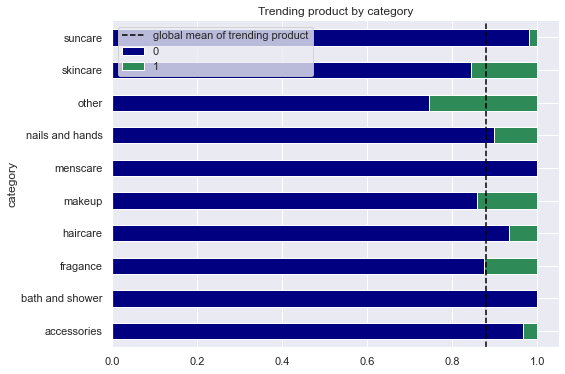

In [248]:
#Creating the bar chart
plt.figure(figsize=(12,8))
column = "category"
trending_pct_df = df_combined.groupby([column,"trending_asin"])[column].count() / df_combined.groupby(column)[column].count()
trending_pct_df.unstack().plot(kind="barh", stacked=True, color=[ "navy","seagreen"])
plt.axvline(.88, c="black", label="global mean of trending product", linestyle="--")
plt.legend()
sns.despine()
plt.title(f"Trending product by {column}")

plt.savefig("category.jpg",bbox_inches = 'tight') 

/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_821/125523894.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_combined.corr(), annot=True, center=0, vmin=-1, vmax=1)


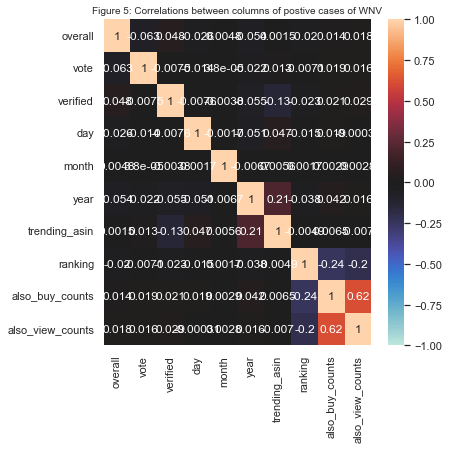

In [237]:
plt.figure(figsize=(6,6))
sns.heatmap(df_combined.corr(), annot=True, center=0, vmin=-1, vmax=1)
plt.title("Figure 5: Correlations between columns of postive cases of WNV", size=10)
plt.show()

In [185]:
asin_counts = clean_review_df.groupby('asin')['asin'].count().sort_values(ascending=False)
asin_counts_df = pd.DataFrame(asin_counts)

In [186]:
q1, q3 = asin_counts.quantile(0.25), asin_counts.quantile(0.75)
iqr = q3-q1
print(f"Interquartile Range is {iqr}")
print(f"Lower quartile captures {q1}")
print(f"Upper quartile captures {q3}")

Interquartile Range is 32.0
Lower quartile captures 3.0
Upper quartile captures 35.0


In [187]:
review_new_df.shape

NameError: name 'review_new_df' is not defined

2327 products remain with counts of over 50 but we still maintain over X% of our original dataset.

In [ ]:
plot = clean_review_df.groupby("overall").count().reset_index()
plot = plot.rename(columns= {"overall":"Review Rating","verified":"Counts of Reviews"})

#plot structure
fig = px.bar(plot, 
             x = "Review Rating",
             y = "Counts of Reviews",
             title = "Amazon users are generous when they review, 65% of the dataset gave out a 5 star review",
             color = "Review Rating",
             color_continuous_scale="darkmint"
             
             )

fig.update_layout(coloraxis_showscale=False)

#plot 
fig.show()